<a href="https://colab.research.google.com/github/robert-altdeep/causalML/blob/new-tutorials/tutorials/verma_independence_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pgmpy

In [ ]:
from functools import partial
import numpy as np
import pandas as pd
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.models import NaiveBayes
import statsmodels.api as sm
from statsmodels.formula.api import ols

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data_url = "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/cigs_and_cancer.csv"
data = pd.read_csv(data_url)
data

,C,S,T,L
0,9.57,Med,Low,True
1,8.80,High,High,False
2,8.33,High,High,True
3,7.72,High,High,True
4,8.00,High,High,True
...,...,...,...,...
95,4.87,High,High,True
96,9.42,High,High,False
97,7.27,Low,Low,False
98,9.31,Low,Low,False


In [ ]:
cost_lower = np.quantile(data["C"], 1/3)
cost_upper = np.quantile(data["C"], 2/3)

def discretize_three(val, lower, upper):
    if val < lower:
        return "Low"
    if val < upper:
        return "Med"
    return "High"

data_disc = data.assign(
    C = lambda df: df['C'].map(
            partial(discretize_three, lower=cost_lower, upper=cost_upper)
        ),
    L = lambda df: df['L'].map(str),
)
data_disc

,C,S,T,L
0,High,Med,Low,True
1,Med,High,High,False
2,Med,High,High,True
3,Med,High,High,True
4,Med,High,High,True
...,...,...,...,...
95,Low,High,High,True
96,High,High,High,False
97,Low,Low,Low,False
98,High,Low,Low,False


In [ ]:
model_L_given_CST = NaiveBayes()
model_L_given_CST.fit(data_disc, 'L', estimator=BayesianEstimator)

infer_L_given_CST = VariableElimination(model_L_given_CST)

def p_L_given_CST(L_val, C_val, S_val, T_val, engine=infer_L_given_CST):

    result_out = engine.query(
        variables=["L"],
        evidence={'C': C_val, 'S': S_val, 'T': T_val},
        show_progress=False
    )

    prob = dict(zip(result_out.state_names["L"], result_out.values))
    return prob[L_val]

In [ ]:
p_L_given_CST("True", "Low", "Low", "Low")

0.6173631165455107

In [ ]:
model_S_given_C = NaiveBayes()
model_S_given_C.fit(data_disc, 'S', estimator=BayesianEstimator)

infer_S_given_C = VariableElimination(model_S_given_C)

def p_S_given_C(S_val, C_val, engine=infer_S_given_C):

    result_out = engine.query(
        variables=['S'],
        evidence={'C': C_val},
        show_progress=False
    )

    prob = dict(zip(result_out.state_names["S"], result_out.values))
    return prob[S_val]

In [ ]:
cstl_outcomes = pd.DataFrame(
    [
        (C, S, T, L)
        for C in ["Low", "Med", "High"]
        for S in ["Low", "Med", "High"]
        for T in ["Low", "High"]
        for L in ["False", "True"]
    ],
    columns = ['C', 'S', 'T', 'L']
)
cstl_outcomes

,C,S,T,L
0,Low,Low,Low,False
1,Low,Low,Low,True
2,Low,Low,High,False
3,Low,Low,High,True
4,Low,Med,Low,False
5,Low,Med,Low,True
6,Low,Med,High,False
7,Low,Med,High,True
8,Low,High,Low,False
9,Low,High,Low,True


In [ ]:
cs_outcomes = pd.DataFrame(
    [
        (C, S)
        for C in ["Low", "Med", "High"]
        for S in ["Low", "Med", "High"]
    ],
    columns = ['C', 'S']
)

In [ ]:
l_cst_dist = cstl_outcomes.assign(
    p_L_CST = cstl_outcomes.apply(
        lambda row: p_L_given_CST(
            row['L'], row['C'], row['S'], row['T']), axis = 1
    )
)
s_c_dist = cs_outcomes.assign(
    p_S_C = cs_outcomes.apply(
        lambda row: p_S_given_C(row['S'], row['C']), axis = 1
    )
)
dist = l_cst_dist.merge(s_c_dist, on=['S', 'C'], how='left')
dist

,C,S,T,L,p_L_CST,p_S_C
0,Low,Low,Low,False,0.382637,0.131410
1,Low,Low,Low,True,0.617363,0.131410
2,Low,Low,High,False,0.243640,0.131410
3,Low,Low,High,True,0.756360,0.131410
4,Low,Med,Low,False,0.602541,0.246795
5,Low,Med,Low,True,0.397459,0.246795
6,Low,Med,High,False,0.440683,0.246795
7,Low,Med,High,True,0.559317,0.246795
8,Low,High,Low,False,0.323069,0.621795
9,Low,High,Low,True,0.676931,0.621795


In [ ]:
dist_mod = dist.assign(
    product = dist.p_L_CST * dist.p_S_C
)

dist_mod

,C,S,T,L,p_L_CST,p_S_C,product
0,Low,Low,Low,False,0.382637,0.131410,0.050282
1,Low,Low,Low,True,0.617363,0.131410,0.081128
2,Low,Low,High,False,0.243640,0.131410,0.032017
3,Low,Low,High,True,0.756360,0.131410,0.099393
4,Low,Med,Low,False,0.602541,0.246795,0.148704
5,Low,Med,Low,True,0.397459,0.246795,0.098091
6,Low,Med,High,False,0.440683,0.246795,0.108758
7,Low,Med,High,True,0.559317,0.246795,0.138037
8,Low,High,Low,False,0.323069,0.621795,0.200882
9,Low,High,Low,True,0.676931,0.621795,0.420912


In [ ]:
dist_verma = dist_mod.groupby(
    ['C', 'T', 'L']
    ).agg('sum').reset_index().drop(
        columns=["p_L_CST", "p_S_C"]
    ).rename(
        columns = {'product':'sum_product'}
    )
dist_verma


,C,T,L,sum_product
0,High,High,False,0.348536
1,High,High,True,0.651464
2,High,Low,False,0.496355
3,High,Low,True,0.503645
4,Low,High,False,0.264353
5,Low,High,True,0.735647
6,Low,Low,False,0.399869
7,Low,Low,True,0.600131
8,Med,High,False,0.373653
9,Med,High,True,0.626347


In [ ]:
df_verma = data_disc.merge(dist_verma, on=['C', 'T', 'L'], how='left')
df_verma

,C,S,T,L,sum_product
0,High,Med,Low,True,0.503645
1,Med,High,High,False,0.373653
2,Med,High,High,True,0.626347
3,Med,High,High,True,0.626347
4,Med,High,High,True,0.626347
...,...,...,...,...,...
95,Low,High,High,True,0.735647
96,High,High,High,False,0.348536
97,Low,Low,Low,False,0.399869
98,High,Low,Low,False,0.496355


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


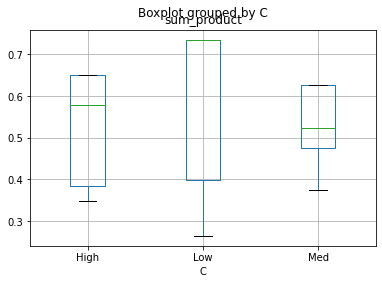

In [ ]:
df_verma.boxplot("sum_product", "C")

In [ ]:
model = ols('sum_product ~ C', data=df_verma).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table["PR(>F)"]["C"]


0.19364363417824293

In [ ]:
model = ols('sum_product ~ T', data=df_verma).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table["PR(>F)"]["T"]


0.07522736142622223

In [ ]:
model = ols('sum_product ~ L', data=df_verma).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table["PR(>F)"]["L"]


7.054785247783856e-28